In [1]:
import torch, pickle, json, os, sys
sys.path.append(os.path.abspath('..'))
from package.utils.data import DataGenerator, collate_fn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Data load and generation

- Load smiles and targets

In [2]:
df_qm9 = pd.read_csv('D:/DATA/polymers/QM9/qm9_origin.csv')
smiles_q, targets_q = df_qm9.values.T[0], df_qm9.values.T[1:].T
with open('D:/DATA/polymers/f-polymer/smiles.json') as f:
    smiles_f = json.load(f)['smiles']
targets_f = np.zeros_like(smiles_f, dtype=float) # dummy target for collate_fn

In [3]:
df = pd.read_csv('D:/DATA/polymers/f-polymer/Fea_Gene_20220603_DieEC_Total.csv')
pd.set_option('display.max_colwidth',15)
df.columns = [c.replace('Normalized_FR','amount') for c in df.columns]
df[~np.sum((df == 'Did not work').values, axis=1).astype(bool)]

,ID,Monomer_A,Monomer_B,Monomer_C,Monomer_D,Monomer_E,amount_A,amount_B,amount_C,amount_D,amount_E,dielectric_constant
0,FA-00149,CC(=C)C(=O)...,CCCCCCCCCCC...,COC(=O)C(C)=C,CC(=C)C(O)=O,CC(=C)C(=O)...,2.00,1.00,4.00,1.00,2.00,1.9600
1,FA-00151,CC(=C)C(=O)...,CCCCCCCCCCC...,COC(=O)C(C)=C,CC(=C)C(O)=O,CC(=C)C(=O)...,4.00,1.00,2.00,1.00,2.00,2.0100
2,FA-00232,CC(=C)C(=O)...,CCCCCCCCCCC...,COC(=O)C(C)=C,CC(=C)C(O)=O,CC(=C)C(=O)...,4.60,1.20,2.00,1.20,2.30,2.1100
3,FA-00218,CC(=C)C(=O)...,CCCCCCCCCCC...,COC(=O)C(C)=C,CC(=C)C(O)=O,CC(=C)C(=O)...,3.59,1.14,1.93,1.12,2.22,2.1100
4,FA-00152,CC(=C)C(=O)...,CCCCCCCCCCC...,COC(=O)C(C)=C,CC(=C)C(O)=O,CC(=C)C(=O)...,6.00,1.00,0.00,1.00,2.00,2.2600
...,...,...,...,...,...,...,...,...,...,...,...,...
208,FA-00382,FC(F)(F)C(F...,CCCCCCCCCCC...,COC(=O)C(C)=C,CC(=C)C(O)=O,CC(=C)C(=O)...,6.00,0.00,3.00,1.00,0.00,2.5056
209,FA-00381,FC(F)(F)C(F...,CCCCCCCCCCC...,COC(=O)C(C)=C,CC(=C)C(O)=O,CC(=C)C(=O)...,6.00,0.00,4.00,0.00,0.00,2.5112
210,FA-00384,FC(F)(F)C(F...,CCCCCCCCCCC...,COC(=O)C(C)=C,CC(=C)C(O)=O,CC(=C)C(=O)...,6.00,0.00,1.00,3.00,0.00,2.6042
211,FA-00385,FC(F)(F)C(F...,CCCCCCCCCCC...,COC(=O)C(C)=C,CC(=C)C(O)=O,CC(=C)C(=O)...,6.00,0.00,0.00,4.00,0.00,2.7735


- generate

In [4]:
DGQ = DataGenerator(smiles=smiles_q, targets=targets_q.astype(float), include_autocorr=True, norm=True)
if os.path.isfile('../unscreened_dataset.qm9.pickle'):
    DGQ = DGQ.load('../unscreened_dataset.qm9.pickle')
else:
    DGQ.generate()

DGF = DataGenerator(smiles=smiles_f, targets=targets_f, include_autocorr=True, norm=True)
if os.path.isfile('../unscreened_dataset.fpoly.pickle'):
    DGF = DGF.load('../unscreened_dataset.fpoly.pickle')
else:
    DGF.generate()

generate: 100%|██████████| 46/46 [00:00<00:00, 319.44it/s]


- merge

In [5]:
atom_q, bond_q, edge_q, mol_q, gidx_q, tgt_q = collate_fn(DGQ.data)
atom_f, bond_f, edge_f, mol_f, gidx_f, tgt_f = collate_fn(DGF.data)

In [6]:
atom_q.shape, bond_q.shape, edge_q.shape, mol_q.shape, DGQ.n_atom_feat, DGQ.n_bond_feat, DGQ.n_mol_feat

(torch.Size([1177631, 26]),
 torch.Size([2517932, 5]),
 torch.Size([2, 2517932]),
 torch.Size([133885, 399]),
 26,
 5,
 399)

- test readout

In [8]:
from torch_geometric.nn import global_mean_pool

x = global_mean_pool(atom_q, gidx_q)
x.shape, tgt_q.shape # well operating

(torch.Size([133885, 26]), torch.Size([133885, 12]))

In [7]:
tmax = torch.max(mol_q, dim=0).values
DGQ.name_mol_feat[np.where((tmax > 100).numpy())[0]]

array([], dtype='<U24')

### Screening

In [9]:
from ypack.utils.features import screen_high_pcc, screen_low_var

#### Atomic features

- screen by variance

In [10]:
mask_vq = screen_low_var(atom_q, names=DGQ.name_atom_feat, th=1e-4, axis=1)
mask_vf = screen_low_var(atom_f, names=DGF.name_atom_feat, th=1e-5, axis=1)

Total 5 features are screened (th: 0.00010)
   Screened indexes:
	 [13 17 18 23 24]
   Screened feature names:
 	 ['block' 'fusion_heat' 'metallic_radius' 'ele_config_d' 'ele_config_f']
   Dimension: (1177631, 26) -> (1177631, 21)
Total 6 features are screened (th: 0.00001)
   Screened indexes:
	 [13 18 20 21 23 24]
   Screened feature names:
 	 ['block' 'metallic_radius' 'period' 'ele_config_s' 'ele_config_d'
 'ele_config_f']
   Dimension: (600, 26) -> (600, 20)


- screen by pcc

In [11]:
mask_pq = screen_high_pcc(atom_q, names=DGQ.name_atom_feat, th=1-1e-3, axis=1)
mask_pf = screen_high_pcc(atom_f, names=DGF.name_atom_feat, th=1-1e-3, axis=1)

Total 3 features are screened (th: 0.99900)
   Screened indexes:
	 [ 6 11 22]
   List of indexes:
	  0 [Mass]               : 11 [atomic_number], 22 [ele_config_p]
	  2 [ImplicitValence]    : 6 [NumImplicitHs]
	 16 [en_pauling]         : 11 [atomic_number], 22 [ele_config_p]
   Screened feature names:
 	 ['NumImplicitHs' 'atomic_number' 'ele_config_p']
   Dimension: (1177631, 26) -> (1177631, 23)
Total 3 features are screened (th: 0.99900)
   Screened indexes:
	 [ 6 11 22]
   List of indexes:
	  2 [ImplicitValence]    : 6 [NumImplicitHs]
	 10 [TotalValence]       : 11 [atomic_number], 22 [ele_config_p]
	 16 [en_pauling]         : 11 [atomic_number], 22 [ele_config_p]
   Screened feature names:
 	 ['NumImplicitHs' 'atomic_number' 'ele_config_p']
   Dimension: (600, 26) -> (600, 23)


c:\Users\Yang\anaconda3\envs\poly\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\Yang\anaconda3\envs\poly\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


- feature mask

In [12]:
mask_atom_feat = mask_vq & mask_vf & mask_pq & mask_pf
np.sum(mask_atom_feat)

16

#### Bond feature

- screen by variance

In [13]:
mask_vq = screen_low_var(bond_q, names=DGQ.name_bond_feat, th=1e-4, axis=1)
mask_vf = screen_low_var(bond_f, names=DGF.name_bond_feat, th=1e-5, axis=1)

Total 0 features are screened (th: 0.00010)
   Screened indexes:
	 []
   Screened feature names:
 	 []
   Dimension: (2517932, 5) -> (2517932, 5)
Total 0 features are screened (th: 0.00001)
   Screened indexes:
	 []
   Screened feature names:
 	 []
   Dimension: (1134, 5) -> (1134, 5)


- screen by pcc

In [14]:
mask_pq = screen_high_pcc(bond_q, names=DGQ.name_bond_feat, th=1-1e-2, axis=1)
mask_pf = screen_high_pcc(bond_f, names=DGF.name_bond_feat, th=1-1e-3, axis=1)

Total 1 features are screened (th: 0.99000)
   Screened indexes:
	 [2]
   List of indexes:
	  0 [BondType]           : 2 [IsAromatic]
   Screened feature names:
 	 ['IsAromatic']
   Dimension: (2517932, 5) -> (2517932, 4)
Total 0 features are screened (th: 0.99900)
   Screened indexes:
	 []
   List of indexes:
   Screened feature names:
 	 []
   Dimension: (1134, 5) -> (1134, 5)


- feature mask

In [15]:
mask_bond_feat = mask_vq & mask_vf & mask_pq & mask_pf
np.sum(mask_bond_feat)

4

#### Molecular feature

- screen by variance

In [16]:
mask_vq = screen_low_var(mol_q, names=DGQ.name_mol_feat, th=1e-4, axis=1)
mask_vf = screen_low_var(mol_f, names=DGF.name_mol_feat, th=1e-5, axis=1)

Total 103 features are screened (th: 0.00010)
   Screened indexes:
	 [  9  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 126 134 140 144 153 154 155 157 159 160 167 168 171
 172 181 182 183 189 190 194 197 198 199 202 203 204 261 262 269 270 277
 278 286 292 293 294 295 296 297 298 299 300 301 302]
   Screened feature names:
 	 ['NumRadicalElectrons' 'PEOE_VSA1' 'PEOE_VSA10' 'PEOE_VSA11' 'PEOE_VSA12'
 'PEOE_VSA13' 'PEOE_VSA14' 'PEOE_VSA2' 'PEOE_VSA3' 'PEOE_VSA4' 'PEOE_VSA5'
 'PEOE_VSA6' 'PEOE_VSA7' 'PEOE_VSA8' 'PEOE_VSA9' 'SMR_VSA1' 'SMR_VSA10'
 'SMR_VSA2' 'SMR_VSA3' 'SMR_VSA4' 'SMR_VSA5' 'SMR_VSA6' 'SMR_VSA7'
 'SMR_VSA8' 'SMR_VSA9' 'SlogP_VSA1' 'SlogP_VSA10' 'SlogP_VSA11'
 'SlogP_VSA12' 'SlogP_VSA2' 'SlogP_VSA3' 'SlogP_VSA4' 'SlogP_VSA5'
 'SlogP_VSA6' 'SlogP_VSA7' 'SlogP_VSA8' 'SlogP_VSA9' 'TPSA' 'ES

- screen by pcc

In [17]:
mask_pq = screen_high_pcc(mol_q, names=DGQ.name_mol_feat, th=1-1e-2, axis=1)
mask_pf = screen_high_pcc(mol_f, names=DGF.name_mol_feat, th=1-1e-3, axis=1)

Total 142 features are screened (th: 0.99000)
   Screened indexes:
	 [  2   6   7   8  10  12  17  18  26  29  32  34  36  38  40  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 111 121 130 131 133 143 182 188 223 224 225 226 227 228 229 230
 239 240 242 243 244 245 246 275 276 277 278 295 296 297 298 299 300 301
 302 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 367
 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 398]
   List of indexes:
	  0 [MaxEStateIndex]     : 2 [MaxAbsEStateIndex]
	  5 [MolWt]              : 6 [HeavyAtomMolWt], 7 [ExactMolWt], 8 [NumValenceElectrons], 10 [MaxPartialCharge], 17 [BCUT2D_MWHI], 18 [BCUT2D_MWLOW], 26 [BertzCT], 40 [Ipc], 43 [LabuteASA], 44 [PEOE_VSA1], 45 [PEOE_VSA10], 46 [PEOE_VSA11], 47 [PEOE_VSA12], 48 [PEOE_VSA13], 49 [PEOE_VS

- feature mask

In [18]:
mask_mol_feat = mask_vq & mask_vf & mask_pq & mask_pf
np.sum(mask_mol_feat)

164

#### Save datasets

- unscreened data

In [19]:
DGQ.save('unscreened_dataset.qm9.pickle')
DGF.save('unscreened_dataset.fpoly.pickle')

- screened data

In [20]:
DGQ.screen_by_mask(mask_atom=mask_atom_feat, 
                   mask_bond=mask_bond_feat, 
                   mask_mol=mask_mol_feat)
DGF.screen_by_mask(mask_atom=mask_atom_feat, 
                   mask_bond=mask_bond_feat, 
                   mask_mol=mask_mol_feat)
DGQ.save('screened_dataset.qm9.pickle', overwrite=True)
DGF.save('screened_dataset.fpoly.pickle', overwrite=True)

screen: 100%|██████████| 46/46 [00:00<00:00, 46003.33it/s]


#### Inspect data for normalization

In [32]:
def get_info(feat):
    f = np.hstack(feat)
    return f'mean: {np.mean(f):>10.3f}\nmedi : {np.median(f):>10.3f}\nmax  : {np.max(f):>10.3f}\nmin   : {np.min(f):>10.3f}\nvar    : {np.var(f):>10.3f}'

6it [00:00, 10.86it/s]


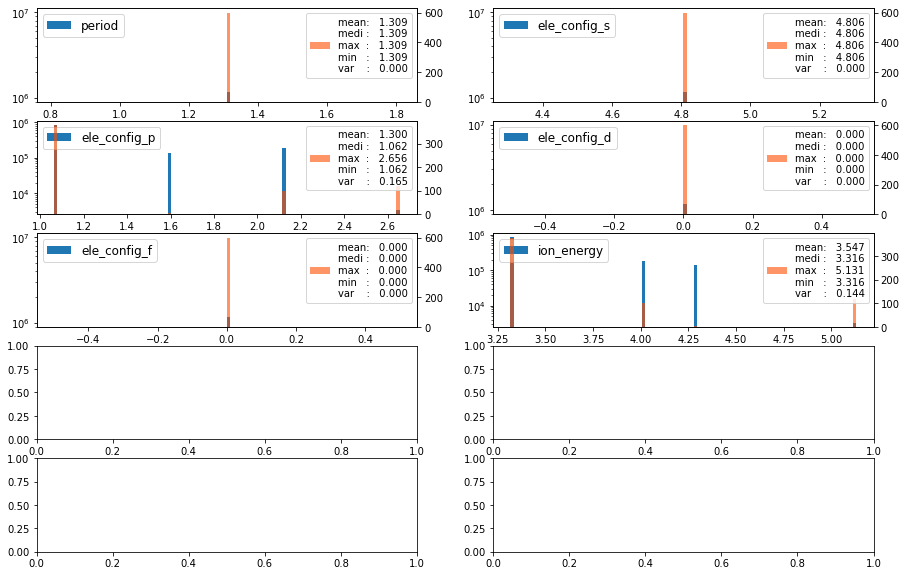

In [31]:
import tqdm
idx=20
f, axs = plt.subplots(5, 2, figsize=(15, 10))
for i, ax in tqdm.tqdm(enumerate(axs.reshape(-1))):
    if i + idx == atom_q.T.shape[0]: break
    n = DGQ.name_atom_feat[i + idx]
    feat1 = atom_q.T[i + idx].numpy()
    ax.hist(feat1, bins=100, label=n)
    feat2 = atom_f.T[i + idx].numpy()
    ax2 = ax.twinx()
    ax2.hist(feat2, bins=100, alpha=0.6, color=[1,0.3,0], label=get_info([feat1, feat2]))
    ax.legend(loc='upper left', fontsize=12)
    ax2.legend(loc='upper right', fontsize=10)
    ax.set_yscale('log')
    